In [1]:
# import
import os, sys
import numpy as np
import pandas as pd
import scipy as sp
from scipy import stats
from scipy.spatial import distance
from sklearn.cluster import KMeans
from tqdm import tqdm

# import plotting libraries
import matplotlib.pyplot as plt

plt.rcParams.update({"font.size": 8})
plt.rcParams["svg.fonttype"] = "none"
import seaborn as sns
from nilearn import datasets
from nilearn import plotting

sys.path.extend([r'/home/lindenmp/research_projects/snaplab_tools'])
sys.path.extend([r'/home/lindenmp/research_projects/nctpy/src'])

# import nctpy functions
from snaplab_tools.plotting.plotting import categorical_kde_plot, reg_plot, brain_scatter_plot, null_plot
from snaplab_tools.plotting.utils import get_my_colors, get_p_val_string
from snaplab_tools.prediction.regression import Regression
from snaplab_tools.utils import get_null_p

from nctpy.plotting import add_module_lines
from nctpy.utils import convert_states_str2int

## Load data

In [2]:
# directory where data is stored
indir = '/home/lindenmp/research_projects/nct_xr/data/mouse'
outdir = '/home/lindenmp/research_projects/nct_xr/data'

In [3]:
A_file = os.path.join(indir, 'normalized_connection_strength_ipsi.csv')
A = np.loadtxt(os.path.join(indir, A_file), dtype=float, delimiter=",", encoding="utf-8-sig")
A = A.T  # set rows=tagets and columns=sources. That is, Aij = edge from node j to node i
print(A.shape)
print(np.all(np.round(A, 4) == np.round(A.T, 4)))

(461, 461)
False


In [4]:
# load region class
region_class = pd.read_csv(os.path.join(indir, "region_class.csv"))

# retain isocortex
idx = region_class["Isocortex"] == 1
# subset A
A = A[region_class[idx].index, :][:, region_class[idx].index]
n_nodes = A.shape[0]
print(A.shape)

# get density including self connections
density = np.count_nonzero(A) / A.shape[0] ** 2
print(density)

# subset region_class
region_class = region_class[idx]

# sort on Isocortex_modules
region_class.reset_index(inplace=True, drop=True)
region_class["sort_idx"] = region_class.index
region_class.sort_values("Isocortex_modules", inplace=True)
region_class.reset_index(inplace=True, drop=True)
# sort A to match
A = A[region_class.sort_idx, :][:, region_class.sort_idx]

print(region_class)

(43, 43)
1.0
     Region  Class  Isocortex Isocortex_modules  sort_idx
0      AUDv      0          1          Auditory        16
1     AUDpo      0          1          Auditory        15
2      AUDp      0          1          Auditory        14
3      AUDd      0          1          Auditory        13
4       ECT     12          1           Lateral        42
5      PERI     12          1           Lateral        41
6        GU     12          1           Lateral        11
7       AId      0          1           Lateral        32
8      VISC     12          1           Lateral        12
9       AIv      0          1           Lateral        34
10      TEa     12          1           Lateral        40
11      AIp      0          1           Lateral        33
12   RSPagl      0          1            Medial        35
13     RSPd      0          1            Medial        36
14     RSPv      0          1            Medial        37
15     VISa      0          1            Medial        38
1

### Plot adjacency

In [5]:
A[np.eye(A.shape[0]) == 1] = 0

['Auditory' 'Lateral' 'Medial' 'PFC' 'Somatomotor' 'Visual']


/tmp/ipykernel_2574163/389514703.py:2: RuntimeWarning: divide by zero encountered in log10
  A_log = np.log10(A)


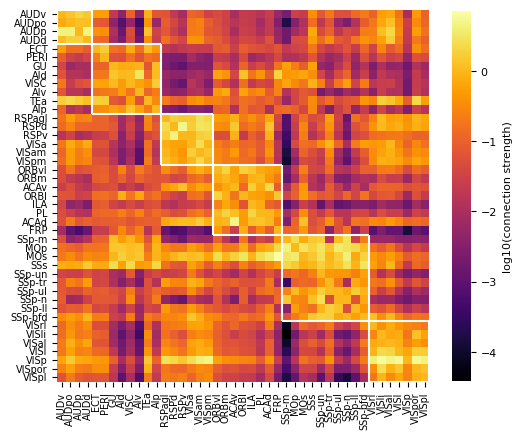

In [6]:
# plot A matrix
A_log = np.log10(A)
A_log[np.eye(A_log.shape[0]) == 1] = 0
f, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(
    A_log,
    ax=ax,
    square=True,
    cmap="inferno",
    xticklabels=region_class.Region,
    yticklabels=region_class.Region,
    cbar_kws={"label": "log10(connection strength)", "shrink": 0.8},
)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=7)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=7)
add_module_lines(region_class["Isocortex_modules"], ax)
f.savefig(
    os.path.join(outdir, "mouse_connectome.png"),
    dpi=600,
    bbox_inches="tight",
    pad_inches=0.01,
)
plt.show()

### Assign isocortex to DMN based on Whitesell 2021 Neuron

In [7]:
# Whitesell DMN regions
dmn_regions = [
    "ACAd",
    "ACAv",
    "PL",
    "ILA",
    "ORBl",
    "ORBm",
    "ORBvl",
    "VISa",
    "VISam",
    "RSPagl",
    "RSPd",
    "RSPv",
    "SSp-tr",
    "SSp-ll",
    "MOs",
]

region_class.set_index("Region", inplace=True)
region_class["DMN"] = np.zeros(n_nodes).astype(bool)
for idx in dmn_regions:
    region_class.loc[idx, "DMN"] = True
region_class.reset_index(inplace=True, drop=False)

# create new system labels column that uses DMN to overwrite existing modules
region_class["system_labels"] = region_class["Isocortex_modules"]
region_class.loc[region_class["DMN"], "system_labels"] = "DMN"

print(region_class)

     Region  Class  Isocortex Isocortex_modules  sort_idx    DMN system_labels
0      AUDv      0          1          Auditory        16  False      Auditory
1     AUDpo      0          1          Auditory        15  False      Auditory
2      AUDp      0          1          Auditory        14  False      Auditory
3      AUDd      0          1          Auditory        13  False      Auditory
4       ECT     12          1           Lateral        42  False       Lateral
5      PERI     12          1           Lateral        41  False       Lateral
6        GU     12          1           Lateral        11  False       Lateral
7       AId      0          1           Lateral        32  False       Lateral
8      VISC     12          1           Lateral        12  False       Lateral
9       AIv      0          1           Lateral        34  False       Lateral
10      TEa     12          1           Lateral        40  False       Lateral
11      AIp      0          1           Lateral     

### Get states

In [8]:
# get system labels
system_labels = list(region_class["system_labels"])

In [9]:
print(len(system_labels))
print(system_labels[:20])

43
['Auditory', 'Auditory', 'Auditory', 'Auditory', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'Lateral', 'DMN', 'DMN', 'DMN', 'DMN', 'DMN', 'Medial', 'DMN', 'DMN']


In [10]:
# use list of system names to create states
states, state_labels = convert_states_str2int(system_labels)
states.shape

(43,)

In [11]:
n_states = len(state_labels)
centroids = np.zeros((n_states, n_nodes))
for i in np.arange(n_states):
    centroids[i, :] = states == i
centroids.shape

(7, 43)

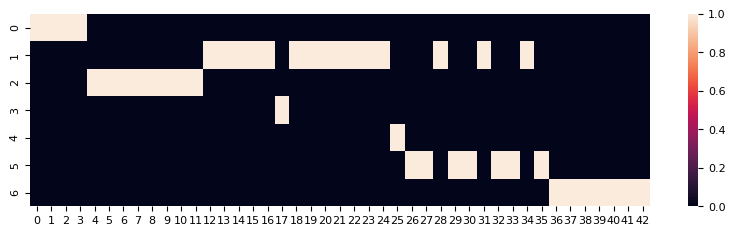

In [12]:
f, ax = plt.subplots(figsize=(10, 2.5))
sns.heatmap(centroids, ax=ax, square=False)
plt.show()

## Save data

In [13]:
file_str = 'mouse_connectome'
np.save(os.path.join(outdir, file_str), A)

my_dict = dict()
my_dict['centroids'] = centroids
file_str = 'mouse_brain_states'
np.save(os.path.join(outdir, file_str), my_dict)